In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

sns.set_context('talk')

**Note:**

Data source: [hotel demand datasets](https://ars.els-cdn.com/content/image/1-s2.0-S2352340918315191-mmc2.zip) from Antonio, et al. (2019).

Paper: Antonio, N., De Almeida, A., & Nunes, L. (2019). Hotel booking demand datasets. Data in Brief, 22, 41-49. https://doi.org/10.1016/j.dib.2018.11.126

In [2]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('data-preparation-data-transformation').getOrCreate()

/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/cloudpickle.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if obj.__module__ is "__builtin__":


We load the transformed data from `1-data-preparation-datatransformation.ipynb`.

In [3]:
import json
from pyspark.sql.types import StructType

## Get schema of the JSON file
with open("hotel_merged_data_transformation_schema.json") as f:
    new_schema = StructType.fromJson(json.load(f))

struct<IsCanceled:int,LeadTime:double,ArrivalDateWeekNumber:int,ArrivalDateDayOfMonth:int,StaysInWeekendNights:int,StaysInWeekNights:int,Adults:int,IsRepeatedGuest:boolean,PreviousCancellations:int,PreviousBookingsNotCanceled:int,DaysInWaitingList:int,ADR:double,HasChild:boolean,RequireCarPark:boolean,HasSpecialRequest:boolean,IsReservedRoomTypeEqualToAssigned:boolean,IsCityHotel:boolean,MealVector:vector,MarketSegmentVector:vector,DistributionChannelVector:vector,DepositTypeVector:vector,CustomerTypeVector:vector,IsTestSet:boolean>


In [5]:
## Read the JSON file based on the saved schema
df_hotel = spark.read.json('hotel_merged_data_transformation.json/',
                          schema = new_schema)

In [4]:
df_hotel.count()

141012

In [6]:
df_hotel.printSchema()

root
 |-- IsCanceled: integer (nullable = true)
 |-- LeadTime: double (nullable = true)
 |-- ArrivalDateWeekNumber: integer (nullable = true)
 |-- ArrivalDateDayOfMonth: integer (nullable = true)
 |-- StaysInWeekendNights: integer (nullable = true)
 |-- StaysInWeekNights: integer (nullable = true)
 |-- Adults: integer (nullable = true)
 |-- IsRepeatedGuest: boolean (nullable = true)
 |-- PreviousCancellations: integer (nullable = true)
 |-- PreviousBookingsNotCanceled: integer (nullable = true)
 |-- DaysInWaitingList: integer (nullable = true)
 |-- ADR: double (nullable = true)
 |-- HasChild: boolean (nullable = true)
 |-- RequireCarPark: boolean (nullable = true)
 |-- HasSpecialRequest: boolean (nullable = true)
 |-- IsReservedRoomTypeEqualToAssigned: boolean (nullable = true)
 |-- IsCityHotel: boolean (nullable = true)
 |-- MealVector: vector (nullable = true)
 |-- MarketSegmentVector: vector (nullable = true)
 |-- DistributionChannelVector: vector (nullable = true)
 |-- DepositTypeV

# 5. Data Mining Method Selection

Supervised learning: classification task.


# 6. Data Mining Algorithm Selection

- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosted Tree

# 7. Data Mining

## 7.1. Create and Justify Test Designs

Train-validation-test. Use k-fold cross validation to estimate the performance in validation set.

We use similar train-test data as we used in feature selection and random oversampling.

In [21]:
## split the dataframe based on previous train-test-split
df_train = df_hotel.filter('IsTestSet == False').drop('IsTestSet')
df_test = df_hotel.filter('IsTestSet == True').drop('IsTestSet')

## 7.2. Conduct Data Mining

Algorithms:
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient-Boosted Tree

These models are evaluated based on accuracy and AUC.


In [67]:
## define k-fold cross cv
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

def kfold_cv(spark_df,
             target_colname, 
             clf,
             k = 10,
             random_seed = 722,
             eval_metric = 'accuracy'):
    """
    Perform k-fold cross-validation using the specified classifier.
    Return the cross-validated model.
    """
    RND = 722
    params = ParamGridBuilder().build()

    assembler = VectorAssembler(
        inputCols = [colname for colname in spark_df.columns if (colname != target_colname)],
        outputCol = 'features'
    )

    pipeline = Pipeline(
        stages = [assembler, clf]
    )

    cv_binary = CrossValidator(
        estimator = pipeline,
        estimatorParamMaps = params,
        evaluator = BinaryClassificationEvaluator(labelCol = target_colname, metricName = 'areaUnderROC'),
        numFolds = k,
        seed = random_seed
    )
    
    cv_multi = CrossValidator(
        estimator = pipeline,
        estimatorParamMaps = params,
        evaluator = MulticlassClassificationEvaluator(labelCol = target_colname, metricName = eval_metric),
        numFolds = k,
        seed = random_seed
    )
    
    ## Same model, but different evaluator
    ## We only want to store the average value of the evaluation metrics
    cv_model_binary = cv_binary.fit(spark_df)
    cv_model_multi = cv_multi.fit(spark_df)
    
    print("AUC: {}".format(cv_model_binary.avgMetrics))
    print("Accuracy: {}".format(cv_model_multi.avgMetrics))
    
    ## Only return one model (both are similar)
    return cv_model_binary

### Logistic Regression

In [68]:
logres = LogisticRegression(maxIter = 10, labelCol = 'IsCanceled')

cv_logres = kfold_cv(df_train, target_colname = 'IsCanceled', clf = logres, k = 5)

AUC: [0.8623119248765567]
Accuracy: [0.7699028342214574]


In [70]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

def evaluate_performance(clf, spark_df, target_colname):
    """
    Evaluate model performance on the given dataset.
    Return the AUC and accuracy.
    """
    binary_evaluator = BinaryClassificationEvaluator(labelCol = target_colname)
    multi_evaluator = MulticlassClassificationEvaluator(
        labelCol = target_colname,
        metricName = 'accuracy'
    )
    
    pred_df = clf.transform(spark_df)
    print("AUC: {}".format(binary_evaluator.evaluate(pred_df)))
    print("Accuracy: {}".format(multi_evaluator.evaluate(pred_df)))
    
    return pred_df

In [72]:
## On overall training set
evaluate_performance(cv_logres, df_train, target_colname = 'IsCanceled')

AUC: 0.862545225115018
Accuracy: 0.7704248753857109


DataFrame[IsCanceled: int, LeadTime: double, ArrivalDateWeekNumber: int, ArrivalDateDayOfMonth: int, StaysInWeekendNights: int, StaysInWeekNights: int, Adults: int, IsRepeatedGuest: boolean, PreviousCancellations: int, PreviousBookingsNotCanceled: int, DaysInWaitingList: int, ADR: double, HasChild: boolean, RequireCarPark: boolean, HasSpecialRequest: boolean, IsReservedRoomTypeEqualToAssigned: boolean, IsCityHotel: boolean, MealVector: vector, MarketSegmentVector: vector, DistributionChannelVector: vector, DepositTypeVector: vector, CustomerTypeVector: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [71]:
## On test set
evaluate_performance(cv_logres, df_test, target_colname = 'IsCanceled')

AUC: 0.8659261022206844
Accuracy: 0.7812648863731891


DataFrame[IsCanceled: int, LeadTime: double, ArrivalDateWeekNumber: int, ArrivalDateDayOfMonth: int, StaysInWeekendNights: int, StaysInWeekNights: int, Adults: int, IsRepeatedGuest: boolean, PreviousCancellations: int, PreviousBookingsNotCanceled: int, DaysInWaitingList: int, ADR: double, HasChild: boolean, RequireCarPark: boolean, HasSpecialRequest: boolean, IsReservedRoomTypeEqualToAssigned: boolean, IsCityHotel: boolean, MealVector: vector, MarketSegmentVector: vector, DistributionChannelVector: vector, DepositTypeVector: vector, CustomerTypeVector: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

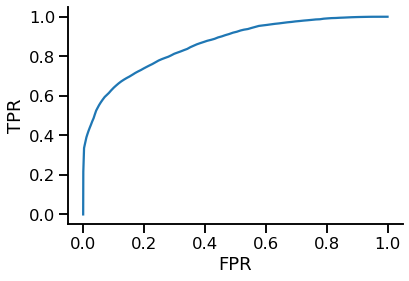

In [84]:
## sample: plot ROC curve
d = cv_logres.bestModel.stages[-1].summary.roc.toPandas()
sns.lineplot(
    x = d['FPR'],
    y = d['TPR']
)
sns.despine();

### Decision Tree